In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    Cont = np.array([])
    SBJ = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta0 = prms['delta0'].values[i]
        delta1 = prms['delta1'].values[i]
        t0 = prms['t0'].values[i]
        
        if model == 'exp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 * np.exp(-lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'hyp':
            b0 = prms['b0'].values[i]
            lamda = prms['lambda'].values[i]
            ub = lambda t: b0 / (1 + lamda*t)
            lb = lambda t: -1*ub(t)
        elif model == 'ddm':
            b0 = prms['b0'].values[i]
            ub = lambda t: b0
            lb = lambda t: -1*ub(t)   

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)
        contrast = sbj_data.contrast.values

        rt = []

        for c in contrast:
#             delta = delta0 - delta1*np.log(c)
            delta = delta0 - delta1*np.log((c/100 - 0.025)/(c/100 + 0.025))
            rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))

        RT = np.concatenate([RT, rt])
        Cont = np.concatenate([Cont, contrast])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'rt': np.abs(RT),
                         'accuracy': RT>0,
                         'contrast': Cont,
                         'g_contrast': Cont//5*5}) 

In [4]:
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//5*5

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [5]:
data['g_contrast'].nunique()

20

In [6]:
hyp_speed = pd.read_csv('_prms/hyp_speed.csv')
hyp_accuracy = pd.read_csv('_prms/hyp_accuracy.csv')
# exp_speed = pd.read_csv('_prms/exp_speed.csv')
exp_speed = pd.read_csv('_prms/exp_speed_log.csv')
# exp_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
exp_accuracy = pd.read_csv('_prms/exp_accuracy_log.csv')
jddm_speed = pd.read_csv('_prms/jddm_speed.csv')
jddm_accuracy = pd.read_csv('_prms/jddm_accuracy.csv')
bddm_speed = pd.read_csv('_prms/bddm_speed.csv')
bddm_accuracy = pd.read_csv('_prms/bddm_accuracy.csv')

In [7]:
hyp_speed.BIC.sum(), exp_speed.BIC.sum(), jddm_speed.BIC.sum(), bddm_speed.BIC.sum()

(-33485.299569258554,
 -32980.9956124213,
 -28636.857642059498,
 4152.399678484208)

In [8]:
hyp_accuracy.BIC.sum(), exp_accuracy.BIC.sum(), jddm_accuracy.BIC.sum(), bddm_accuracy.BIC.sum()

(-11078.958630232759,
 -9909.880949243667,
 -8632.652745820278,
 17508.068115963622)

In [ ]:
pred_hyp_sp = get_model_prediction(hyp_speed, data_speed, 'hyp')
pred_hyp_ac = get_model_prediction(hyp_accuracy, data_accuracy, 'hyp')

In [9]:
pred_exp_sp = get_model_prediction(exp_speed, data_speed, 'exp')
pred_exp_ac = get_model_prediction(exp_accuracy, data_accuracy, 'exp')

100%|█████████████████████████████████████████| 26/26 [01:23<00:00,  3.19s/it]


In [ ]:
pred_jddm_sp = get_model_prediction(jddm_speed, data_speed, 'ddm')
pred_jddm_ac = get_model_prediction(jddm_accuracy, data_accuracy, 'ddm')

In [ ]:
pred_bddm_sp = get_model_prediction(bddm_speed, data_speed, 'ddm')
pred_bddm_ac = get_model_prediction(bddm_accuracy, data_accuracy, 'ddm')

In [11]:
def plot_model_pred(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 26)
    temp = pred.groupby(by=['sbj', 'g_contrast'])[var].mean()
    temp = pd.DataFrame(np.array([temp[i].values for i in pred.sbj.unique()]), 
                        columns=[j*5 for j in range(20)])
    plt.errorbar(x= x + pred.groupby(by='g_contrast')['g_contrast'].mean(), 
                 y= pred.groupby(by='g_contrast')[var].mean(),
                 yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*5 for j in range(20)]]), 
                 label=label, c=color);

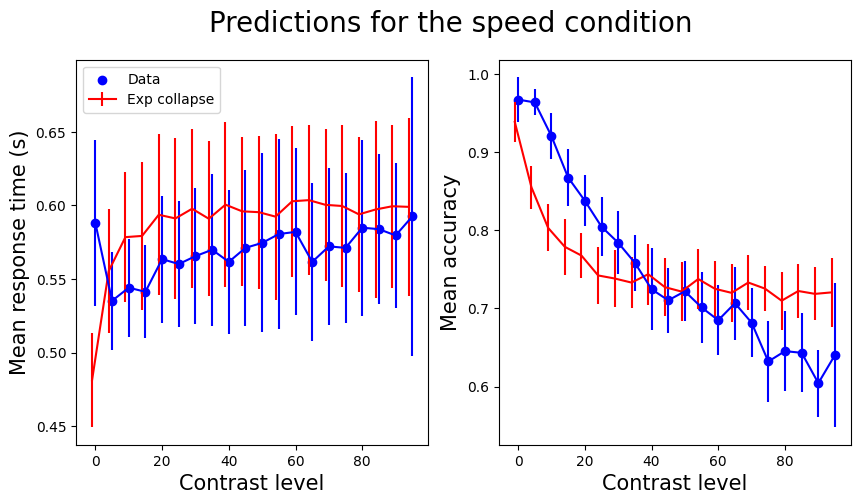

In [12]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)
# plot_model_pred(pred_hyp_sp, 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'rt', 'red', -1, 'Exp collapse')
# plot_model_pred(pred_jddm_sp, 'rt', 'green', 1, 'JDDM')
# plot_model_pred(pred_bddm_sp, 'rt', 'pink', 2, 'BDDM collapse')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_speed.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*5 for j in range(20)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*5 for j in range(20)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

plt.subplot(122)
# plot_model_pred(pred_hyp_sp, 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_sp, 'accuracy', 'red', -1, 'Exp collapse')
# plot_model_pred(pred_jddm_sp, 'accuracy', 'green', 1, 'JDDM')
# plot_model_pred(pred_bddm_sp, 'accuracy', 'pink', 2, 'BDDM collapse')

temp = data_speed.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*5 for j in range(20)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*5 for j in range(20)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);
# plt.legend();

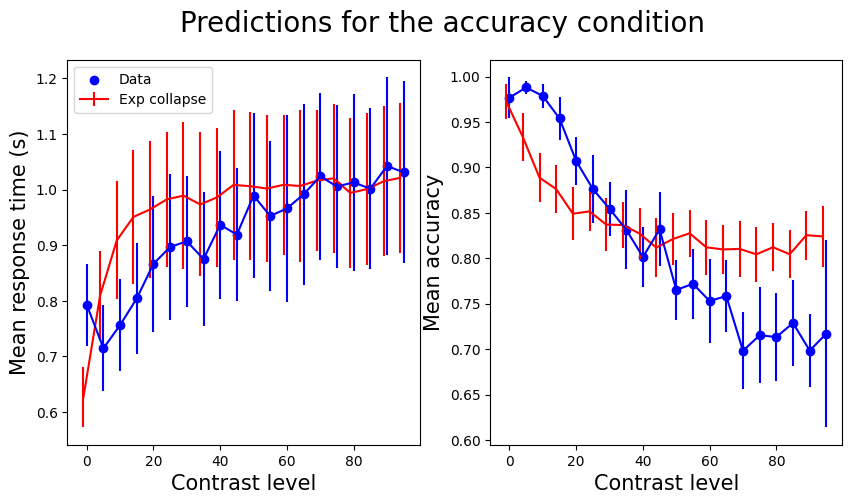

In [13]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

plt.subplot(121)

# plot_model_pred(pred_hyp_ac, 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_ac, 'rt', 'red', -1, 'Exp collapse')
# plot_model_pred(pred_jddm_ac, 'rt', 'green', 1, 'JDDM')

err = scipy.stats.t.ppf(0.975, 26)
temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*5 for j in range(20)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*5 for j in range(20)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend(loc='upper left');

plt.subplot(122)
# plot_model_pred(pred_hyp_ac, 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp_ac, 'accuracy', 'red', -1, 'Exp collapse')
# plot_model_pred(pred_jddm_ac, 'accuracy', 'green', 1, 'JDDM collapse')

temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*5 for j in range(20)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*5 for j in range(20)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15);
# plt.legend();